<a href="https://colab.research.google.com/github/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/VGG19_Diagnosis_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG19 Model Visualize Architecture

This notebook applied a pre-trained model to a dataset specified in the configuration file and uploads the labels to the catalog.  The ROC curve is also calculated and uploaded.


In [16]:
# Prerequisites to configure colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install deriva
    !pip install bdbag
    !pip install --upgrade --force pydantic
    !pip install git+https://github.com/informatics-isi-edu/deriva-ml git+https://github.com/informatics-isi-edu/eye-ai-ml
    !pip install setuptools_git_versioning


In [17]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Prerequisites

import json
import os
from eye_ai.eye_ai import EyeAI
import pandas as pd
from pathlib import Path, PurePath
import logging
# import torch

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

In [19]:

from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
catalog_id = "eye-ai" #@param
host = 'www.eye-ai.org'


gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2024-06-26 15:21:53,180 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 15:21:53,181 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


Connect to Eye-AI catalog.  Configure to store data local cache and working directories.  Initialize Eye-AI for pending execution based on the provided configuration file.

In [20]:
# Variables to configure the rest of the notebook.

cache_dir = '/data'        # Directory in which to cache materialized BDBags for datasets
working_dir = '/data'    # Directory in which to place output files for later upload.

configuration_rid="2-C8K8" #2-C6DP"      # Configuration file for this run.  Needs to be changed for each execution.

In [21]:
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2024-06-26 15:21:54,078 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 15:21:54,078 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [22]:
# @title Initiate an Execution
configuration_records = EA.execution_init(configuration_rid=configuration_rid)
# input_dataset = configuration_records.bag_paths[0] # Assumes that the configuration file only specifies one dataset.
configuration_records.model_dump()



2024-06-26 15:21:54,468 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_june_26_best_params_model_architecture_visualiz.json] transfer successful. 0.80 KB transferred. Elapsed time: 0:00:00.000112.
2024-06-26 15:21:54,468 - INFO - Verifying SHA256 checksum for downloaded file [/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_june_26_best_params_model_architecture_visualiz.json]
2024-06-26 15:21:54,484 - INFO - Configuration validation successful!
2024-06-26 15:22:00,483 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5] transfer successful. 232.71 MB transferred at 43.30 MB/second. Elapsed time: 0:00:05.374727.
2024-06-26 15:22:00,770 - INFO - File [/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json] transfer succes

{'caching_dir': PosixPath('/data'),
 'working_dir': PosixPath('/data/sreenidhi/EyeAI_working'),
 'vocabs': {'Workflow_Type': [{'name': 'VGG19_Visualize_Model_Architecture',
    'rid': '2-C8KC'}],
  'Diagnosis_Tag': [{'name': 'VGG19_Visualize_Model_Architecture',
    'rid': '2-C8KE'}]},
 'execution_rid': '2-C8ME',
 'workflow_rid': '2-C8KG',
 'bag_paths': [],
 'assets_paths': [PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5'),
  PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json')],
 'configuration_path': PosixPath('/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_june_26_best_params_model_architecture_visualiz.json')}

Algorithm was trained on cropped images, so take the raw images and bounding boxes and apply, storing the results in the working directory.

In [23]:
configuration_records

ConfigurationRecord(caching_dir=PosixPath('/data'), working_dir=PosixPath('/data/sreenidhi/EyeAI_working'), vocabs={'Workflow_Type': [Term(name='VGG19_Visualize_Model_Architecture', rid='2-C8KC')], 'Diagnosis_Tag': [Term(name='VGG19_Visualize_Model_Architecture', rid='2-C8KE')]}, execution_rid='2-C8ME', workflow_rid='2-C8KG', bag_paths=[], assets_paths=[PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5'), PosixPath('/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json')], configuration_path=PosixPath('/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_june_26_best_params_model_architecture_visualiz.json'))

In [24]:
str(EA.working_dir)

'/data/sreenidhi/EyeAI_working'

In [25]:
model_path = str(configuration_records.assets_paths[0])
model_path

'/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Catalog_LAC_DHS_Cropped_Data_exlcuding_no_Optic_disc_fundus_Trained_model_June_24_2024.h5'

In [26]:
best_hyper_parameters_json_path = str(configuration_records.assets_paths[1])
best_hyper_parameters_json_path

'/data/sreenidhi/EyeAI_working/Execution_Assets/best_hyperparameters_exluding_no_optic_disc_images_june_24_2024.json'

In [29]:

output_path = str(EA.working_dir) + "/Execution_Assets/" + configuration_records.vocabs['Execution_Asset_Type'][0].name
os.mkdir(output_path)

KeyError: 'Execution_Asset_Type'

Import the actual model code and then run against the input dataset specified in the configuration file.  

In [27]:
# @title Execute Proecss algorithm (Test model)
from eye_ai.models.vgg19_visualize_model_architecture import visualize_model_architecture

with EA.execution(execution_rid=configuration_records.execution_rid) as exec:
  output_path = EA.execution_assets_path/Path("VGG19_Model_Architecture.png")
  visualize_model_architecture(model_path, output_path)

Model architecture diagram saved to /data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Model_Architecture.png at 300 DPI


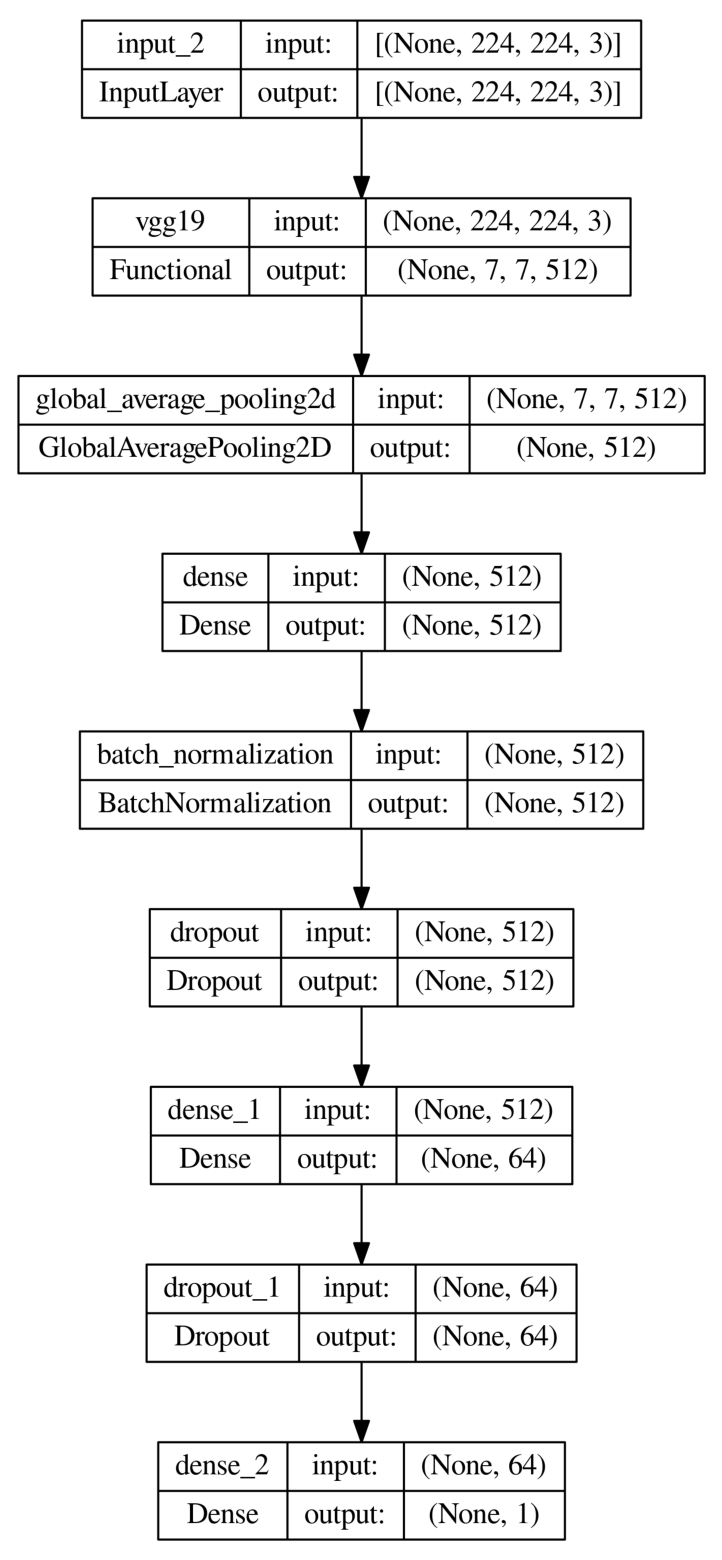

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

image_path = Path("/data/sreenidhi/EyeAI_working/Execution_Assets/VGG19_Model_Architecture.png")
if image_path.is_file():
    img = mpimg.imread(str(image_path))
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"File not found at {image_path}. Please check the path.")

Add the new lables to the catalog using the provided diagnosis tage for this execution.  Also upload any additional assets that were produced by this execution..

In [15]:
# @title Save Execution Assets (model) and Metadata
uploaded_assets = EA.execution_upload(configuration_records.execution_rid, True)


2024-06-26 15:16:54,641 - INFO - Initializing uploader: GenericUploader v1.7.1 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2024-06-26 15:16:54,642 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-06-26 15:16:54,643 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2024-06-26 15:16:54,678 - INFO - Checking for updated configuration...
2024-06-26 15:16:54,827 - INFO - Updated configuration found.
2024-06-26 15:16:54,828 - INFO - Scanning files in directory [/data/sreenidhi/EyeAI_working/Execution_Metadata]...
2024-06-26 15:16:54,833 - INFO - Including file: [/data/sreenidhi/EyeAI_working/Execution_Metadata/Execution_Config-Vgg19_final_model_LAC_DHS_june_26_best_params_model_architecture_visualiz.json].
2024-06-26 15:16:54,833 - INFO - Including file: [/data/